## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,95.9,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,84.0,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,95.2,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,97.6,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,98.4,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2


In [2]:
df.shape

(10871, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 34), (10847,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 34), (8696,), (1087, 24, 34), (1087,), (1064, 24, 34), (1064,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

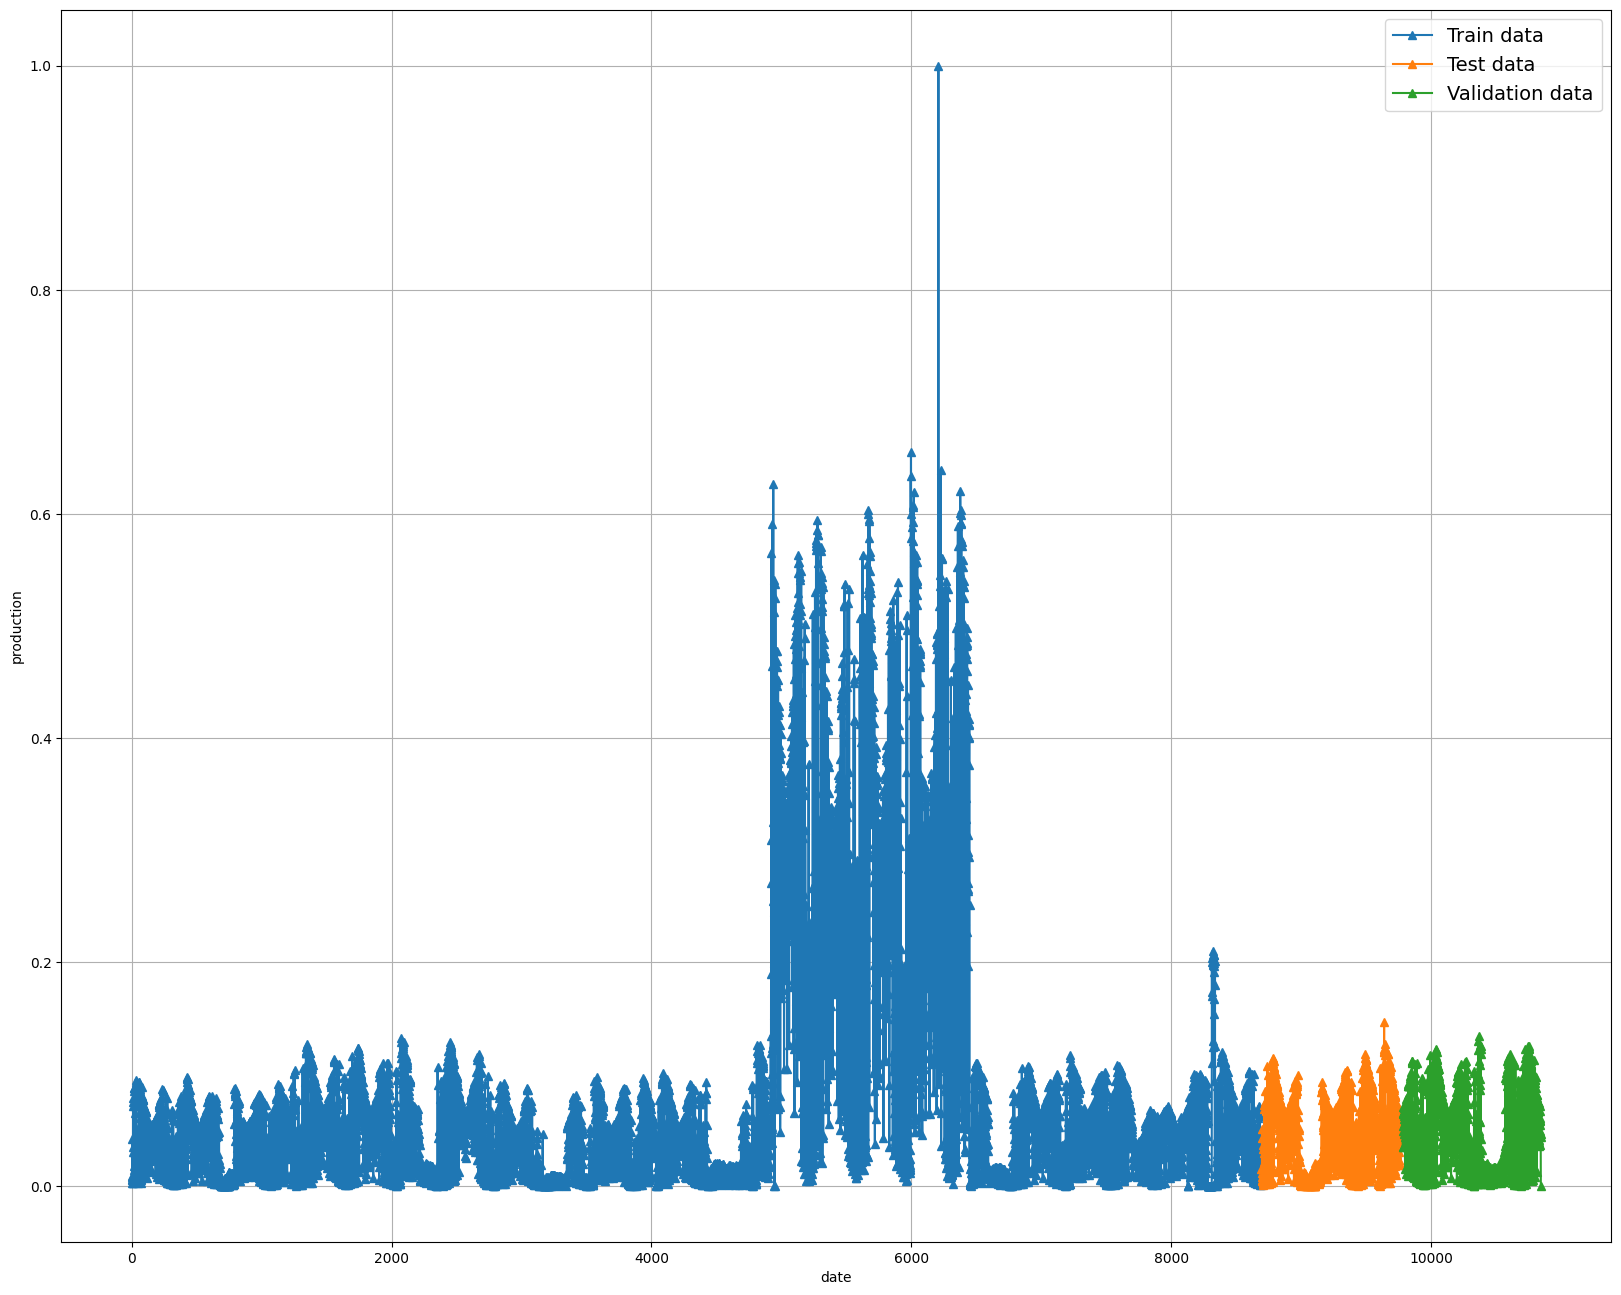

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 34) -> (8696, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='relu',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=16, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0013603946616864242))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 16)               │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,681 (123.75 KB)

 Trainable params: 31,681 (123.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:00:14] [setup] RAM Tracking...
[codecarbon INFO @ 03:00:14] [setup] CPU Tracking...
[codecarbon WARNING @ 03:00:14] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 03:00:16] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 03:00:16] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 03:00:16] [setup] GPU Tracking...
[codecarbon INFO @ 03:00:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:00:16] >>> Tracker's metadata:
[codecarbon INFO @ 03:00:16]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 03:00:16]   Python version: 3.12.3
[codecarbon INFO @ 03:00:16]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:00:16]   Available RAM : 15.288 GB
[codecarbon INFO @ 03:00:16]   CPU count: 16
[codecarbon INFO @ 03:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0662 - val_loss: 0.0292
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0444 - val_loss: 0.0289
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0408 - val_loss: 0.0280
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0400 - val_loss: 0.0280
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0397 - val_loss: 0.0281
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0393 - val_loss: 0.0281
Epoch 7/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0389

[codecarbon INFO @ 03:00:28] Energy consumed for RAM : 0.000017 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:00:28] Energy consumed for all CPUs : 0.000124 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0392 - val_loss: 0.0279
Epoch 8/300


[codecarbon INFO @ 03:00:29] Energy consumed for all GPUs : 0.000009 kWh. Total GPU Power : 3.0056573372743136 W
[codecarbon INFO @ 03:00:29] 0.000149 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0387 - val_loss: 0.0276
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0381 - val_loss: 0.0278
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0380 - val_loss: 0.0282
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0378 - val_loss: 0.0267
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0370 - val_loss: 0.0268
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0367 - val_loss: 0.0258
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0362 - val_loss: 0.0252
Epoch 15/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0359 - val_loss: 0.0269
Epoch 16/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0361 - val_loss: 0.0246
Epoch 17/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0350 - val_loss: 0.0244
Epoch 18/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0347 - val_loss: 0.0242
Epoch 19/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - lo

[codecarbon INFO @ 03:00:38] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:00:39] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0344 - val_loss: 0.0234
Epoch 20/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0325

[codecarbon INFO @ 03:00:39] Energy consumed for all GPUs : 0.000018 kWh. Total GPU Power : 3.4396458491109265 W
[codecarbon INFO @ 03:00:39] 0.000286 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0340 - val_loss: 0.0231
Epoch 21/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0334 - val_loss: 0.0224
Epoch 22/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0330 - val_loss: 0.0222
Epoch 23/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0331 - val_loss: 0.0222
Epoch 24/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0322 - val_loss: 0.0220
Epoch 25/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0323 - val_loss: 0.0216
Epoch 26/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0322 - val_loss: 0.0213
Epoch 27/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0322 - val_loss: 0.0215
Epoch 28/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0316 - val_loss: 0.0208
Epoch 29/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0319 - val_loss: 0.0219
Epoch 30/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0315 - val_loss: 0.0221
Epoch 31/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

[codecarbon INFO @ 03:00:48] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:00:48] Energy consumed for all CPUs : 0.000349 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0316

[codecarbon INFO @ 03:00:49] Energy consumed for all GPUs : 0.000029 kWh. Total GPU Power : 4.125827894055606 W
[codecarbon INFO @ 03:00:49] 0.000425 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0317 - val_loss: 0.0206
Epoch 33/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0313 - val_loss: 0.0205
Epoch 34/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0311 - val_loss: 0.0202
Epoch 35/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0306 - val_loss: 0.0198
Epoch 36/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0308 - val_loss: 0.0204
Epoch 37/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0309 - val_loss: 0.0203
Epoch 38/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0309 - val_loss: 0.0196
Epoch 39/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0304 - val_loss: 0.0196
Epoch 40/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0301 - val_loss: 0.0194
Epoch 41/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0301 - val_loss: 0.0190
Epoch 42/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0303 - val_loss: 0.0202
Epoch 43/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

[codecarbon INFO @ 03:00:58] Energy consumed for RAM : 0.000062 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:00:58] Energy consumed for all CPUs : 0.000462 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0311

[codecarbon INFO @ 03:00:59] Energy consumed for all GPUs : 0.000040 kWh. Total GPU Power : 4.0835382300432626 W
[codecarbon INFO @ 03:00:59] 0.000564 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0311 - val_loss: 0.0196
Epoch 45/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0302 - val_loss: 0.0206
Epoch 46/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0304 - val_loss: 0.0197
Epoch 47/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0304 - val_loss: 0.0200
Epoch 48/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0301 - val_loss: 0.0192
Epoch 49/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0303 - val_loss: 0.0204
Epoch 50/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0312 - val_loss: 0.0190
Epoch 51/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0297 - val_loss: 0.0194
Epoch 52/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0293 - val_loss: 0.0184
Epoch 53/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0292 - val_loss: 0.0185
Epoch 54/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0293 - val_loss: 0.0193
Epoch 55/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

[codecarbon INFO @ 03:01:08] Energy consumed for RAM : 0.000077 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:01:09] Energy consumed for all CPUs : 0.000575 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0298

[codecarbon INFO @ 03:01:09] Energy consumed for all GPUs : 0.000051 kWh. Total GPU Power : 4.235402374789136 W
[codecarbon INFO @ 03:01:09] 0.000703 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0298 - val_loss: 0.0192
Epoch 58/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0297 - val_loss: 0.0189
Epoch 59/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0294 - val_loss: 0.0198
Epoch 60/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0289 - val_loss: 0.0183
Epoch 61/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0288 - val_loss: 0.0192
Epoch 62/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0288 - val_loss: 0.0181
Epoch 63/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0284 - val_loss: 0.0180
Epoch 64/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0285 - val_loss: 0.0186
Epoch 65/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0285 - val_loss: 0.0182
Epoch 66/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0284 - val_loss: 0.0202
Epoch 67/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0286 - val_loss: 0.0185
Epoch 68/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - l

[codecarbon INFO @ 03:01:18] Energy consumed for RAM : 0.000092 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:01:19] Energy consumed for all CPUs : 0.000688 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0285 - val_loss: 0.0184
Epoch 70/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0278

[codecarbon INFO @ 03:01:19] Energy consumed for all GPUs : 0.000062 kWh. Total GPU Power : 4.105612475119894 W
[codecarbon INFO @ 03:01:19] 0.000842 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0284 - val_loss: 0.0197
Epoch 71/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0285 - val_loss: 0.0183
Epoch 72/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0291 - val_loss: 0.0193
Epoch 73/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0294 - val_loss: 0.0193
Epoch 74/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0291 - val_loss: 0.0180
Epoch 75/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0283 - val_loss: 0.0178
Epoch 76/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0287 - val_loss: 0.0191
Epoch 77/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0281 - val_loss: 0.0180
Epoch 78/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0279 - val_loss: 0.0177
Epoch 79/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0275 - val_loss: 0.0180
Epoch 80/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0272 - val_loss: 0.0175
Epoch 81/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

[codecarbon INFO @ 03:01:29] Energy consumed for RAM : 0.000108 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:01:29] Energy consumed for all CPUs : 0.000800 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0272

[codecarbon INFO @ 03:01:29] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 3.778173127117422 W
[codecarbon INFO @ 03:01:29] 0.000980 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0272 - val_loss: 0.0178
Epoch 83/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0272 - val_loss: 0.0183
Epoch 84/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0270 - val_loss: 0.0176
Epoch 85/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0269 - val_loss: 0.0182
Epoch 86/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0268 - val_loss: 0.0173
Epoch 87/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0264 - val_loss: 0.0173
Epoch 88/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0266 - val_loss: 0.0189
Epoch 89/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0267 - val_loss: 0.0178
Epoch 90/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0269 - val_loss: 0.0174
Epoch 91/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0269 - val_loss: 0.0175
Epoch 92/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0270 - val_loss: 0.0170
Epoch 93/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

[codecarbon INFO @ 03:01:39] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:01:39] Energy consumed for all CPUs : 0.000913 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0264

[codecarbon INFO @ 03:01:39] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 3.8745768278602566 W
[codecarbon INFO @ 03:01:39] 0.001118 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0266 - val_loss: 0.0177
Epoch 96/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0267 - val_loss: 0.0187
Epoch 97/300


[codecarbon INFO @ 03:01:40] 0.000207 g.CO2eq/s mean an estimation of 6.534580919613187 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0270 - val_loss: 0.0174
Epoch 98/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0261 - val_loss: 0.0192
Epoch 99/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0268 - val_loss: 0.0166
Epoch 100/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0265 - val_loss: 0.0178
Epoch 101/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0260 - val_loss: 0.0173
Epoch 102/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0259 - val_loss: 0.0168
Epoch 103/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0257 - val_loss: 0.0170
Epoch 104/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0255 - val_loss: 0.0179
Epoch 105/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0257 - val_loss: 0.0172
Epoch 106/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0251 - val_loss: 0.0176
Epoch 107/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0256

[codecarbon INFO @ 03:01:49] Energy consumed for RAM : 0.000138 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:01:49] Energy consumed for all CPUs : 0.001026 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0256 - val_loss: 0.0171
Epoch 108/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0250

[codecarbon INFO @ 03:01:49] Energy consumed for all GPUs : 0.000093 kWh. Total GPU Power : 4.037380396088531 W
[codecarbon INFO @ 03:01:49] 0.001257 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0254 - val_loss: 0.0162
Epoch 109/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0253 - val_loss: 0.0164
Epoch 110/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0252 - val_loss: 0.0170
Epoch 111/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0254 - val_loss: 0.0177
Epoch 112/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0249 - val_loss: 0.0160
Epoch 113/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0251 - val_loss: 0.0164
Epoch 114/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0256 - val_loss: 0.0160
Epoch 115/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 116/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0247 - val_loss: 0.0164
Epoch 117/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0249 - val_loss: 0.0166
Epoch 118/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0247 - val_loss: 0.0160
Epoch 119/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43

[codecarbon INFO @ 03:01:59] Energy consumed for RAM : 0.000153 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:01:59] Energy consumed for all CPUs : 0.001139 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0247 - val_loss: 0.0165
Epoch 121/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0236

[codecarbon INFO @ 03:01:59] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 4.155466043007348 W
[codecarbon INFO @ 03:01:59] 0.001396 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0247 - val_loss: 0.0164
Epoch 122/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0243 - val_loss: 0.0159
Epoch 123/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0248 - val_loss: 0.0162
Epoch 124/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0243 - val_loss: 0.0153
Epoch 125/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0242 - val_loss: 0.0158
Epoch 126/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0245 - val_loss: 0.0160
Epoch 127/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0246 - val_loss: 0.0158
Epoch 128/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0243 - val_loss: 0.0173
Epoch 129/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0246 - val_loss: 0.0155
Epoch 130/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0248 - val_loss: 0.0157
Epoch 131/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0242 - val_loss: 0.0162
Epoch 132/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43

[codecarbon INFO @ 03:02:09] Energy consumed for RAM : 0.000168 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:02:09] Energy consumed for all CPUs : 0.001252 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0237

[codecarbon INFO @ 03:02:09] Energy consumed for all GPUs : 0.000115 kWh. Total GPU Power : 4.160288347965015 W
[codecarbon INFO @ 03:02:09] 0.001535 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0238 - val_loss: 0.0160
Epoch 134/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0240 - val_loss: 0.0156
Epoch 135/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0237 - val_loss: 0.0158
Epoch 136/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0240 - val_loss: 0.0166
Epoch 137/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0246 - val_loss: 0.0165
Epoch 138/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0245 - val_loss: 0.0169
Epoch 139/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0238 - val_loss: 0.0165
Epoch 140/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0245 - val_loss: 0.0166
Epoch 141/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0255 - val_loss: 0.0181
Epoch 142/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0257 - val_loss: 0.0150
Epoch 143/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0235 - val_loss: 0.0150
Epoch 144/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44

[codecarbon INFO @ 03:02:19] Energy consumed for RAM : 0.000184 kWh. RAM Power : 5.732982158660889 W


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0245

[codecarbon INFO @ 03:02:19] Energy consumed for all CPUs : 0.001365 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0245

[codecarbon INFO @ 03:02:19] Energy consumed for all GPUs : 0.000127 kWh. Total GPU Power : 4.345507190721168 W
[codecarbon INFO @ 03:02:19] 0.001675 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0246 - val_loss: 0.0159
Epoch 147/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0236 - val_loss: 0.0160
Epoch 148/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0239 - val_loss: 0.0157
Epoch 149/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0233 - val_loss: 0.0151
Epoch 150/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0226 - val_loss: 0.0151
Epoch 151/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0227 - val_loss: 0.0148
Epoch 152/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0231 - val_loss: 0.0156
Epoch 153/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0236 - val_loss: 0.0153
Epoch 154/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0235 - val_loss: 0.0148
Epoch 155/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0229 - val_loss: 0.0147
Epoch 156/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0228 - val_loss: 0.0150
Epoch 157/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45

[codecarbon INFO @ 03:02:29] Energy consumed for RAM : 0.000199 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:02:29] Energy consumed for all CPUs : 0.001478 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0229 - val_loss: 0.0151
Epoch 159/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0227

[codecarbon INFO @ 03:02:29] Energy consumed for all GPUs : 0.000136 kWh. Total GPU Power : 3.7446331842531753 W
[codecarbon INFO @ 03:02:29] 0.001813 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0229 - val_loss: 0.0163
Epoch 160/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0236 - val_loss: 0.0144
Epoch 161/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0225 - val_loss: 0.0144
Epoch 162/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0220 - val_loss: 0.0141
Epoch 163/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0223 - val_loss: 0.0156
Epoch 164/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0230 - val_loss: 0.0141
Epoch 165/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0219 - val_loss: 0.0144
Epoch 166/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0221 - val_loss: 0.0142
Epoch 167/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0216 - val_loss: 0.0143
Epoch 168/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0217 - val_loss: 0.0143
Epoch 169/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0220 - val_loss: 0.0143
Epoch 170/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46

[codecarbon INFO @ 03:02:39] Energy consumed for RAM : 0.000214 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:02:39] Energy consumed for all CPUs : 0.001591 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0228

[codecarbon INFO @ 03:02:39] Energy consumed for all GPUs : 0.000148 kWh. Total GPU Power : 4.345556657169512 W
[codecarbon INFO @ 03:02:39] 0.001953 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0229 - val_loss: 0.0153
Epoch 172/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0225 - val_loss: 0.0143
Epoch 173/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0213 - val_loss: 0.0139
Epoch 174/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0210 - val_loss: 0.0138
Epoch 175/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0208 - val_loss: 0.0145
Epoch 176/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0217 - val_loss: 0.0151
Epoch 177/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0217 - val_loss: 0.0141
Epoch 178/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0216 - val_loss: 0.0140
Epoch 179/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0204 - val_loss: 0.0139
Epoch 180/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0204 - val_loss: 0.0138
Epoch 181/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0205 - val_loss: 0.0139
Epoch 182/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45

[codecarbon INFO @ 03:02:49] Energy consumed for RAM : 0.000229 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:02:49] Energy consumed for all CPUs : 0.001703 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0216 - val_loss: 0.0146
Epoch 184/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0231

[codecarbon INFO @ 03:02:49] Energy consumed for all GPUs : 0.000159 kWh. Total GPU Power : 4.2148134076413735 W
[codecarbon INFO @ 03:02:49] 0.002091 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0219 - val_loss: 0.0143
Epoch 185/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0210 - val_loss: 0.0136
Epoch 186/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0206 - val_loss: 0.0140
Epoch 187/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0208 - val_loss: 0.0153
Epoch 188/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0220 - val_loss: 0.0153
Epoch 189/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0211 - val_loss: 0.0145
Epoch 190/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0207 - val_loss: 0.0140
Epoch 191/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0203 - val_loss: 0.0139
Epoch 192/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0202 - val_loss: 0.0135
Epoch 193/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0199 - val_loss: 0.0141
Epoch 194/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0200 - val_loss: 0.0136
Epoch 195/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47

[codecarbon INFO @ 03:02:59] Energy consumed for RAM : 0.000244 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:02:59] Energy consumed for all CPUs : 0.001816 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0198

[codecarbon INFO @ 03:02:59] Energy consumed for all GPUs : 0.000171 kWh. Total GPU Power : 4.467593591433112 W
[codecarbon INFO @ 03:02:59] 0.002232 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0198 - val_loss: 0.0135
Epoch 197/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0204 - val_loss: 0.0138
Epoch 198/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0203

[codecarbon INFO @ 03:03:01] 0.000209 g.CO2eq/s mean an estimation of 6.577641462198507 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0204 - val_loss: 0.0142
Epoch 199/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0210 - val_loss: 0.0146
Epoch 200/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0206 - val_loss: 0.0145
Epoch 201/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0204 - val_loss: 0.0140
Epoch 202/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0199 - val_loss: 0.0138
Epoch 203/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0206 - val_loss: 0.0140
Epoch 204/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0206 - val_loss: 0.0139
Epoch 205/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0198 - val_loss: 0.0134
Epoch 206/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0196 - val_loss: 0.0139
Epoch 207/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0199 - val_loss: 0.0142
Epoch 208/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0199

[codecarbon INFO @ 03:03:09] Energy consumed for RAM : 0.000259 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:03:09] Energy consumed for all CPUs : 0.001929 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0199 - val_loss: 0.0131
Epoch 209/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0197

[codecarbon INFO @ 03:03:09] Energy consumed for all GPUs : 0.000182 kWh. Total GPU Power : 4.005002857814109 W
[codecarbon INFO @ 03:03:09] 0.002370 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0198 - val_loss: 0.0133
Epoch 210/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0198 - val_loss: 0.0132
Epoch 211/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0198 - val_loss: 0.0141
Epoch 212/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0207 - val_loss: 0.0140
Epoch 213/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0205 - val_loss: 0.0136
Epoch 214/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0197 - val_loss: 0.0140
Epoch 215/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0199 - val_loss: 0.0138
Epoch 216/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0191 - val_loss: 0.0133
Epoch 217/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0189 - val_loss: 0.0132
Epoch 218/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0189 - val_loss: 0.0127
Epoch 219/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0184 - val_loss: 0.0131
Epoch 220/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44

[codecarbon INFO @ 03:03:19] Energy consumed for RAM : 0.000275 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:03:19] Energy consumed for all CPUs : 0.002042 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0186 - val_loss: 0.0129
Epoch 222/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0195

[codecarbon INFO @ 03:03:19] Energy consumed for all GPUs : 0.000191 kWh. Total GPU Power : 3.575712791769439 W
[codecarbon INFO @ 03:03:19] 0.002508 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0184 - val_loss: 0.0134
Epoch 223/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0181 - val_loss: 0.0128
Epoch 224/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0186 - val_loss: 0.0139
Epoch 225/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0185 - val_loss: 0.0130
Epoch 226/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0185 - val_loss: 0.0128
Epoch 227/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0182 - val_loss: 0.0144
Epoch 228/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0190 - val_loss: 0.0143
Epoch 229/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0195 - val_loss: 0.0136
Epoch 230/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0199 - val_loss: 0.0158
Epoch 231/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0207 - val_loss: 0.0132
Epoch 232/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0185 - val_loss: 0.0130
Epoch 233/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44

[codecarbon INFO @ 03:03:29] Energy consumed for RAM : 0.000290 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:03:29] Energy consumed for all CPUs : 0.002155 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0182

[codecarbon INFO @ 03:03:29] Energy consumed for all GPUs : 0.000201 kWh. Total GPU Power : 3.6015777997181067 W
[codecarbon INFO @ 03:03:29] 0.002645 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0182 - val_loss: 0.0133
Epoch 235/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0181 - val_loss: 0.0135
Epoch 236/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0180 - val_loss: 0.0130
Epoch 237/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0189 - val_loss: 0.0134
Epoch 238/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0199 - val_loss: 0.0146
Epoch 239/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0199 - val_loss: 0.0135
Epoch 240/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0193 - val_loss: 0.0131
Epoch 241/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0186 - val_loss: 0.0132
Epoch 242/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0184 - val_loss: 0.0128
Epoch 243/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0188 - val_loss: 0.0126
Epoch 244/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0186 - val_loss: 0.0137
Epoch 245/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46

[codecarbon INFO @ 03:03:39] Energy consumed for RAM : 0.000305 kWh. RAM Power : 5.732982158660889 W


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0200

[codecarbon INFO @ 03:03:39] Energy consumed for all CPUs : 0.002268 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0178

[codecarbon INFO @ 03:03:39] Energy consumed for all GPUs : 0.000210 kWh. Total GPU Power : 3.455316854424932 W
[codecarbon INFO @ 03:03:39] 0.002783 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0177 - val_loss: 0.0129
Epoch 248/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0183 - val_loss: 0.0127
Epoch 249/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0177 - val_loss: 0.0130
Epoch 250/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0177 - val_loss: 0.0127
Epoch 251/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0174 - val_loss: 0.0126
Epoch 252/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0176 - val_loss: 0.0126
Epoch 253/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0174 - val_loss: 0.0125
Epoch 254/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0175 - val_loss: 0.0127
Epoch 255/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0178 - val_loss: 0.0132
Epoch 256/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0179 - val_loss: 0.0128
Epoch 257/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0178 - val_loss: 0.0133
Epoch 258/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45

[codecarbon INFO @ 03:03:49] Energy consumed for RAM : 0.000320 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:03:49] Energy consumed for all CPUs : 0.002381 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0181 - val_loss: 0.0127
Epoch 260/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0182

[codecarbon INFO @ 03:03:49] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 4.078277097450123 W
[codecarbon INFO @ 03:03:49] 0.002922 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0180 - val_loss: 0.0134
Epoch 261/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0180 - val_loss: 0.0123
Epoch 262/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0170 - val_loss: 0.0123
Epoch 263/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0168 - val_loss: 0.0119
Epoch 264/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0166 - val_loss: 0.0122
Epoch 265/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0170 - val_loss: 0.0125
Epoch 266/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0168 - val_loss: 0.0122
Epoch 267/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0162 - val_loss: 0.0128
Epoch 268/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0164 - val_loss: 0.0128
Epoch 269/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0171 - val_loss: 0.0123
Epoch 270/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0163 - val_loss: 0.0125
Epoch 271/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46

[codecarbon INFO @ 03:03:59] Energy consumed for RAM : 0.000335 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:03:59] Energy consumed for all CPUs : 0.002494 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0166

[codecarbon INFO @ 03:03:59] Energy consumed for all GPUs : 0.000232 kWh. Total GPU Power : 4.068931488913688 W
[codecarbon INFO @ 03:03:59] 0.003061 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0166 - val_loss: 0.0116
Epoch 273/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0161 - val_loss: 0.0120
Epoch 274/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0166 - val_loss: 0.0115
Epoch 275/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0168 - val_loss: 0.0119
Epoch 276/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0172 - val_loss: 0.0120
Epoch 277/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0170 - val_loss: 0.0125
Epoch 278/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0166 - val_loss: 0.0130
Epoch 279/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0166 - val_loss: 0.0123
Epoch 280/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0161 - val_loss: 0.0121
Epoch 281/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0163 - val_loss: 0.0135
Epoch 282/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0170 - val_loss: 0.0127
Epoch 283/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45

[codecarbon INFO @ 03:04:09] Energy consumed for RAM : 0.000350 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:04:09] Energy consumed for all CPUs : 0.002606 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0162 - val_loss: 0.0128
Epoch 285/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0169

[codecarbon INFO @ 03:04:09] Energy consumed for all GPUs : 0.000242 kWh. Total GPU Power : 3.890954392383343 W
[codecarbon INFO @ 03:04:09] 0.003199 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0169 - val_loss: 0.0123
Epoch 286/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0166 - val_loss: 0.0123
Epoch 287/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0167 - val_loss: 0.0118
Epoch 288/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0163 - val_loss: 0.0116
Epoch 289/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0158 - val_loss: 0.0113
Epoch 290/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0157 - val_loss: 0.0117
Epoch 291/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0156 - val_loss: 0.0122
Epoch 292/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 293/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0161 - val_loss: 0.0118
Epoch 294/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0157 - val_loss: 0.0114
Epoch 295/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0150 - val_loss: 0.0112
Epoch 296/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44

[codecarbon INFO @ 03:04:19] Energy consumed for RAM : 0.000366 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:04:19] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0146

[codecarbon INFO @ 03:04:19] Energy consumed for all GPUs : 0.000254 kWh. Total GPU Power : 4.444542386879936 W
[codecarbon INFO @ 03:04:19] 0.003339 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0146 - val_loss: 0.0114
Epoch 298/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0151 - val_loss: 0.0117
Epoch 299/300


[codecarbon INFO @ 03:04:20] 0.000207 g.CO2eq/s mean an estimation of 6.542712139702874 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 300/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0152 - val_loss: 0.0116


[codecarbon INFO @ 03:04:22] Energy consumed for RAM : 0.000370 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 03:04:22] Energy consumed for all CPUs : 0.002749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:04:22] Energy consumed for all GPUs : 0.000262 kWh. Total GPU Power : 12.557343247495064 W
[codecarbon INFO @ 03:04:22] 0.003380 kWh of electricity used since the beginning.


#### Ploting the loss

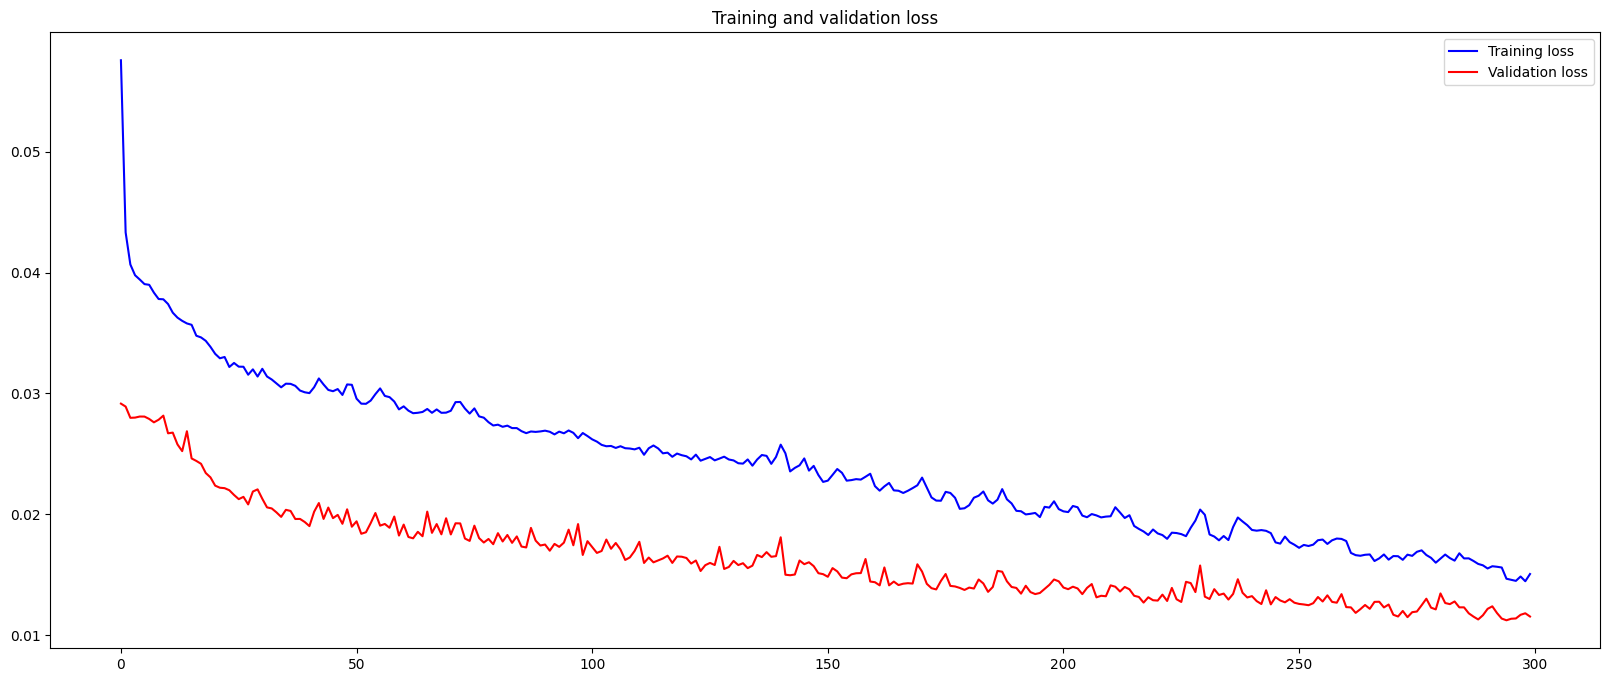

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step  


{'mae': np.float32(0.009089067),
 'mse': np.float32(0.0002090115),
 'r2': 0.8132263422012329}

#### Plot predictions

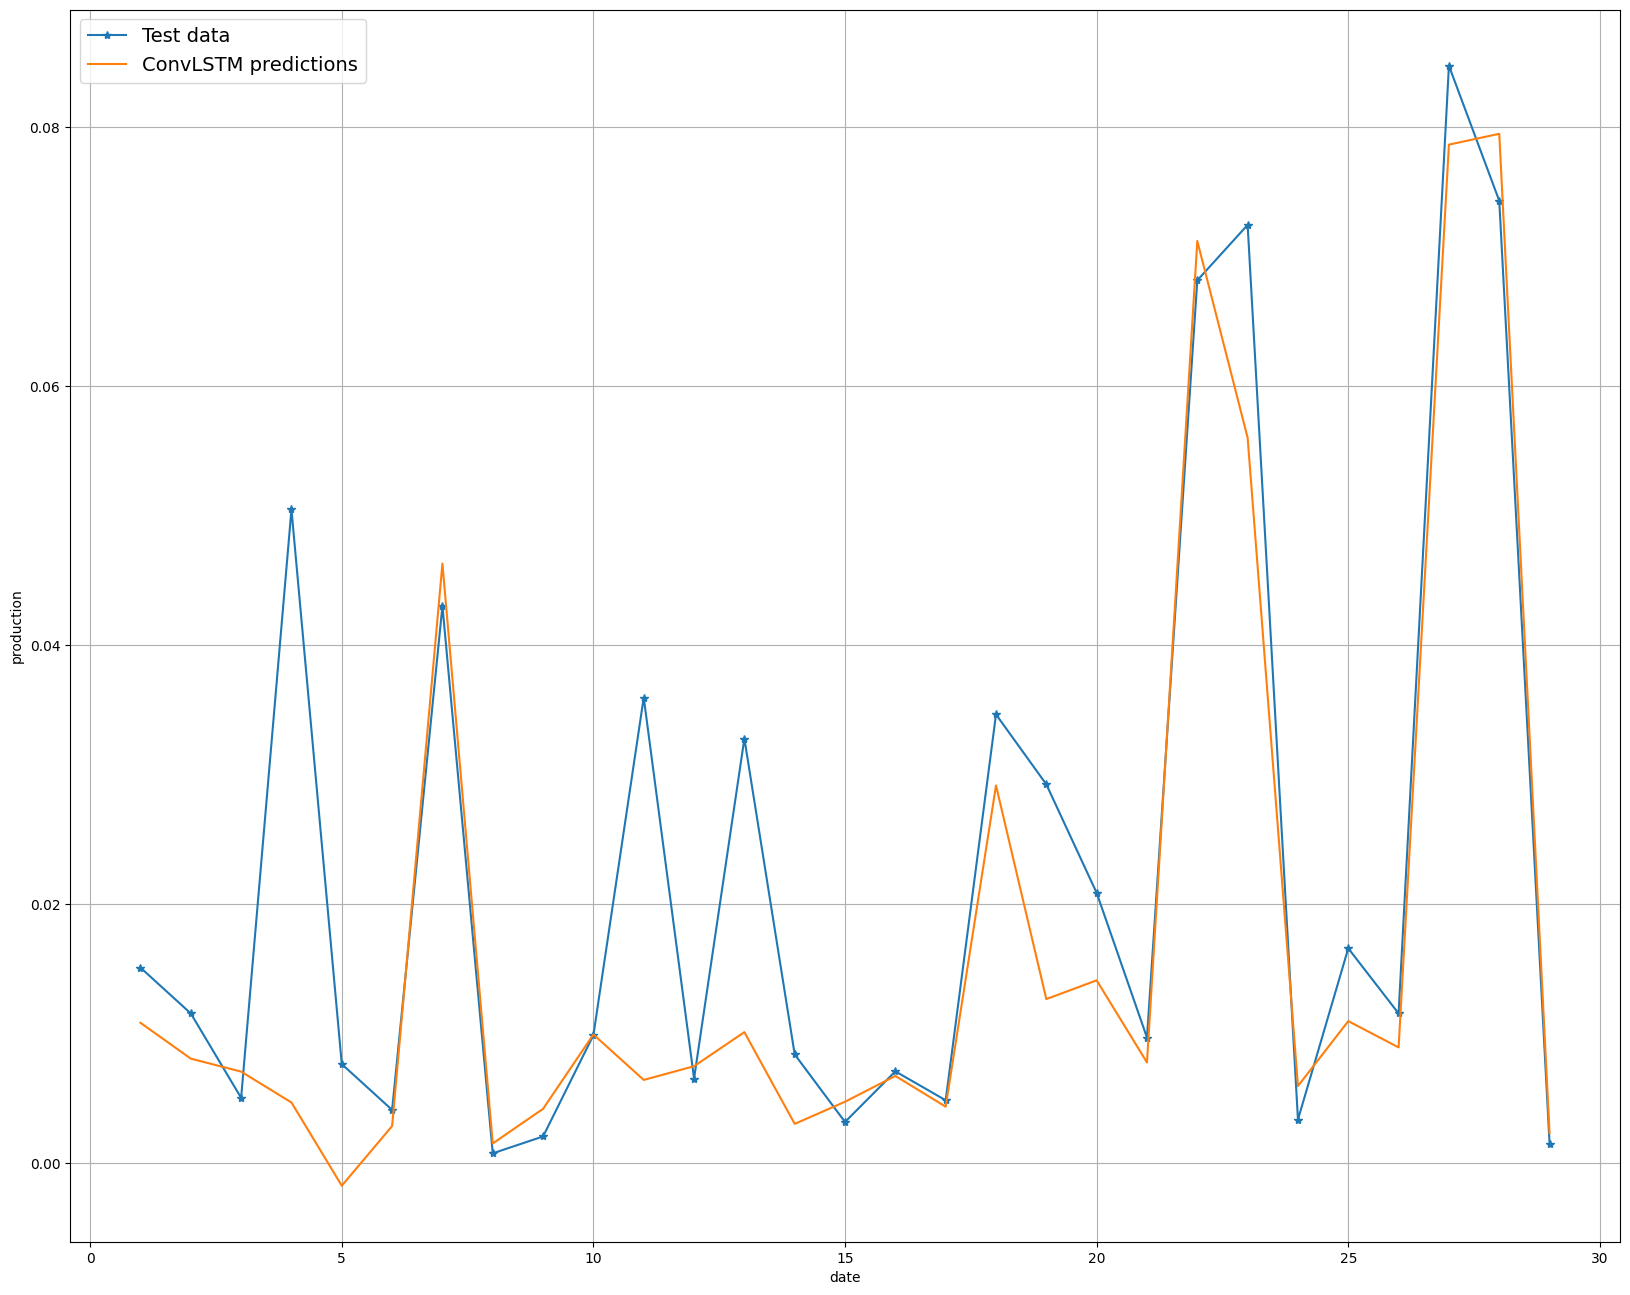

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)